## Wstęp


W tym notebooku zostanie stworzony model, aby przeprowadzić predykcję czy pacjent posiada chorobę serca.

Zostaną użyte następujące algorytmy:
- Regresja logistyczna (manualna i z sklearn)
- Algorytm k-najbliższych sąsiadów
- SVC
- Naiwny klasyfikator Bayesa
- Algorytm drzewa decyzyjnego
- Las losowy


Każdy z algorytmów będzie miał obliczoną precyzję, następnie zostaną  porównane między sobą według tego wskaźnika, a na koniec wyliczone zostaną macierze pomyłek. 

## Dane

Zbiór posiada następujące dane: 

- age - wiek w latach
- sex - 1 - mężczyzna, 0 - kobieta
- cp - typ bólu w klatce piersiowej
- trestbps - ciśnienie krwi w spoczynku (mm Hg)
- chol - cholesterol (mg/dl)
- fbs - Flaga, czy ilość cukru przekroczyła 120mg/dl na czczo. 1 - tak, 0 - nie
- restecg - dane elektrokardiograficzne w spoczynku
- thalach - maksymalne tętno
- exang - czy wystąpiła dławica piersiowa - 1 - tak, 0 - nie
- oldpeak - obniżenie odcinka ST podczas ćwiczeń relatywnie do odpoczynku
- slope - nachylenie szczytu ćwiczeń odcinka ST
- ca - liczba specjalnych naczyń krwionośnych (0-3) 
- thal - Taśma wzgórza -  3 = norma; 6 = naprawiona wada; 7 = odwracalna wada
- target - czy ma chorobę serca (tak - 1, nie - 0)


### Wczytywanie danych

In [1]:
#Import potrzebnych bibliotek

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#Dane znajdują się w pliku heart.csv

df = pd.read_csv("heart.csv")

#pierwsze 5 rekordów
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Sprawdzanie i ewentualne oczyszczanie danych




Kolumny zostały sprawdzone w kontekście przydatności do predykcji oraz dalszej analizy i żadna nie została usunięta.

In [2]:
#Sprawdzenie, czy któraś kolumna posiada wartości null.
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Żaden rekord nie posiada wartości null.

In [3]:
#Czy są jakieś zduplikowane dane?
df.duplicated().sum()

1

Wykryto duplikat, zostanie on usunięty.

In [4]:
#Usunięcie duplikatów
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [5]:
#Informacje o danych
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 302
Data columns (total 14 columns):
age         302 non-null int64
sex         302 non-null int64
cp          302 non-null int64
trestbps    302 non-null int64
chol        302 non-null int64
fbs         302 non-null int64
restecg     302 non-null int64
thalach     302 non-null int64
exang       302 non-null int64
oldpeak     302 non-null float64
slope       302 non-null int64
ca          302 non-null int64
thal        302 non-null int64
target      302 non-null int64
dtypes: float64(1), int64(13)
memory usage: 35.4 KB


### Wstępna analiza danych

In [6]:
#Sprawdzamy ilość osób z chorobą serca i bez
df.target.value_counts()

1    164
0    138
Name: target, dtype: int64

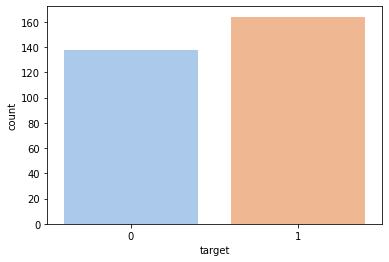

In [7]:
sns.countplot(x="target", data = df, palette="pastel" )

In [8]:
withDiseaseCount = len(df[df.target == 1])
withoutDiseaseCount = len(df[df.target == 0])
print("Ludzie bez choroby serca: {:.2f}%".format((withoutDiseaseCount / (len(df.target))*100)))
print("Ludzie z chorobą serca: {:.2f}%".format((withDiseaseCount / (len(df.target))*100)))

Ludzie bez choroby serca: 45.70%
Ludzie z chorobą serca: 54.30%


In [9]:
femaleCount = len(df[df.sex == 0])
maleCount = len(df[df.sex == 1])
print("Kobiety: {:.2f}%".format((femaleCount / (len(df.sex))*100)))
print("Mężczyźni: {:.2f}%".format((maleCount / (len(df.sex))*100)))

Kobiety: 31.79%
Mężczyźni: 68.21%


In [10]:
withDisease = df[df.target == 1]

femalewithDiseaseCount = len(withDisease[withDisease.sex == 0])
maleWithDiseaseCount = len(withDisease[withDisease.sex == 1])

print("Chore kobiety: {:.2f}%".format((femalewithDiseaseCount / (len(withDisease))*100)))
print("Chorzy mężczyźni: {:.2f}%".format((maleWithDiseaseCount / (len(withDisease))*100)))

Chore kobiety: 43.90%
Chorzy mężczyźni: 56.10%


In [11]:
#Groupby według target
df.groupby('target').mean()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
target,,,,,,,,,,,,,
0,56.601449,0.826087,0.478261,134.398551,251.086957,0.159420,0.449275,139.101449,0.550725,1.585507,1.166667,1.166667,2.543478
1,52.585366,0.560976,1.371951,129.250000,242.640244,0.140244,0.591463,158.378049,0.140244,0.586585,1.591463,0.341463,2.121951


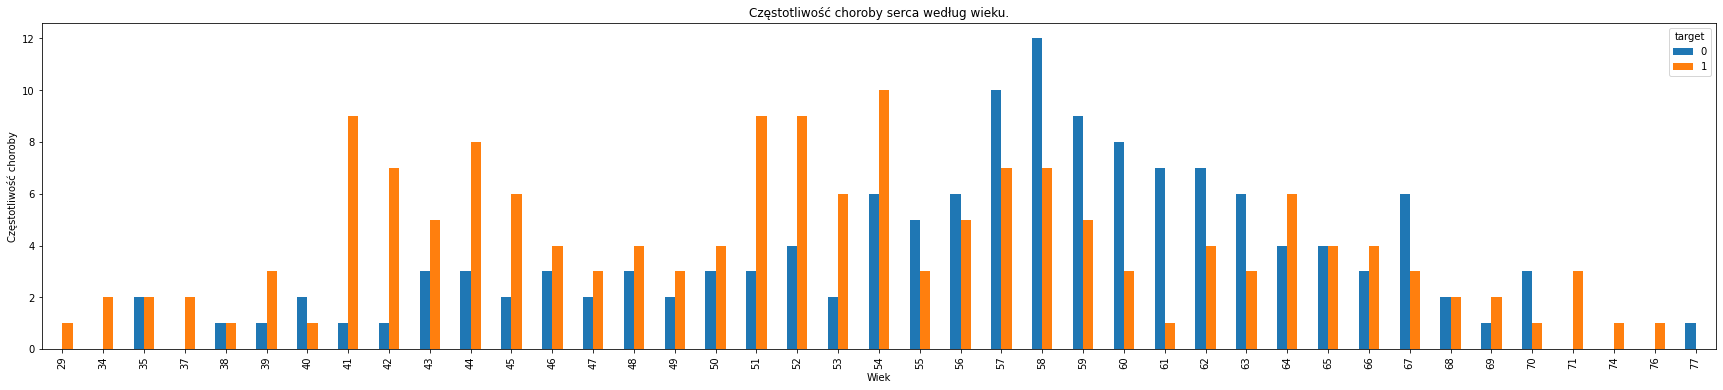

In [12]:
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(30,6))
plt.title('Częstotliwość choroby serca według wieku.')
plt.xlabel('Wiek')
plt.ylabel('Częstotliwość choroby')
plt.show()

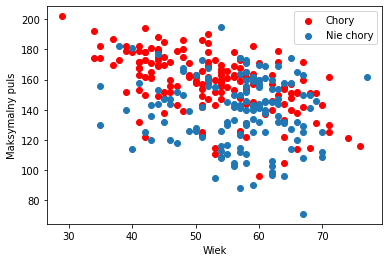

In [13]:
plt.scatter(x=df.age[df.target==1], y=df.thalach[(df.target==1)], c="red")
plt.scatter(x=df.age[df.target==0], y=df.thalach[(df.target==0)])
plt.legend(["Chory", "Nie chory"])
plt.xlabel("Wiek")
plt.ylabel("Maksymalny puls")
plt.show()

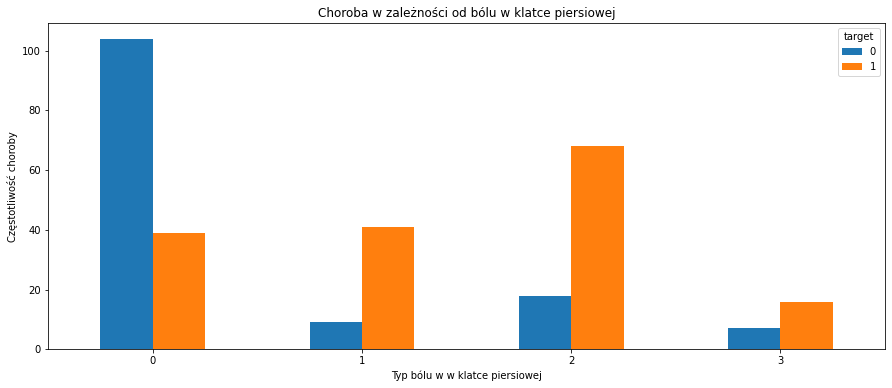

In [14]:
pd.crosstab(df.cp,df.target).plot(kind="bar",figsize=(15,6))
plt.title('Choroba w zależności od bólu w klatce piersiowej')
plt.xlabel('Typ bólu w w klatce piersiowej')
plt.xticks(rotation = 0)
plt.ylabel('Częstotliwość choroby')
plt.show()

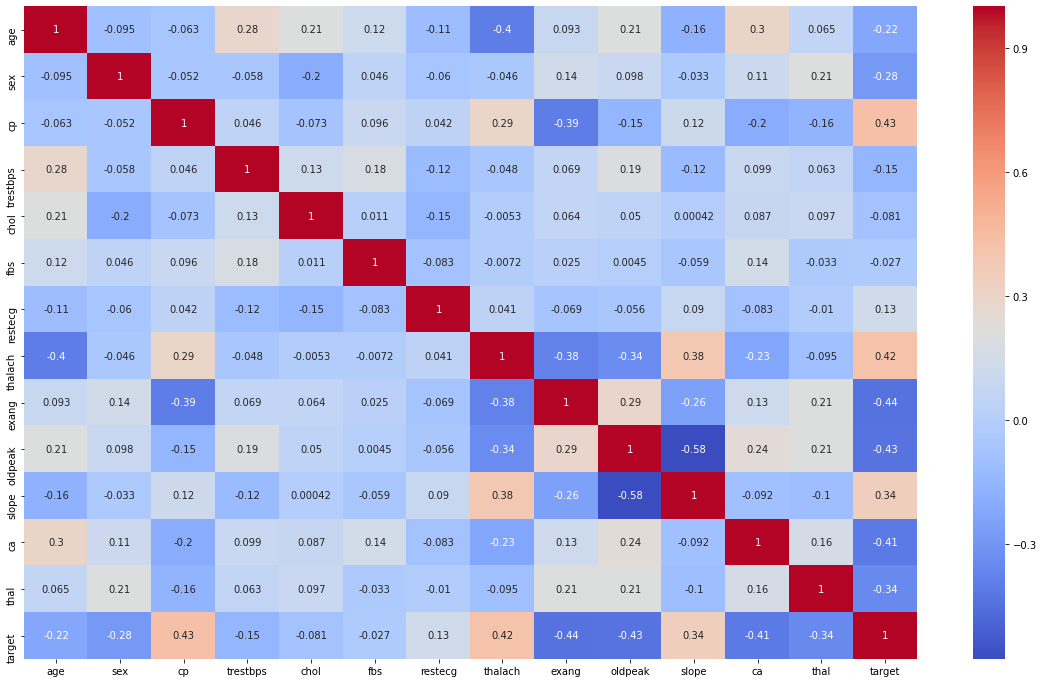

In [15]:
#Wyliczenie korelacji mędzy danymi i wyświetlenie heatmapy
corr=df.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.show()

Jak widać dzięki heatmapie, największą wpływ na chorobę(target) mają: maksymalne tętno (thalach), slope, typ bólu w klatce (cp).


In [16]:
# cp, thai i slope są zmiennymi kategorialnymi. Możemy je zmienić je na 'placeholdery'

a = pd.get_dummies(df['cp'], prefix = "cp")
b = pd.get_dummies(df['thal'], prefix = "thal")
c = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, a, b, c]
df = pd.concat(frames, axis = 1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,3,145,233,1,0,150,0,2.3,...,0,0,1,0,1,0,0,1,0,0
1,37,1,2,130,250,0,1,187,0,3.5,...,0,1,0,0,0,1,0,1,0,0
2,41,0,1,130,204,0,0,172,0,1.4,...,1,0,0,0,0,1,0,0,0,1
3,56,1,1,120,236,0,1,178,0,0.8,...,1,0,0,0,0,1,0,0,0,1
4,57,0,0,120,354,0,1,163,1,0.6,...,0,0,0,0,0,1,0,0,0,1


In [17]:
df = df.drop(columns = ['cp', 'thal', 'slope'])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,145,233,1,0,150,0,2.3,0,...,0,0,1,0,1,0,0,1,0,0
1,37,1,130,250,0,1,187,0,3.5,0,...,0,1,0,0,0,1,0,1,0,0
2,41,0,130,204,0,0,172,0,1.4,0,...,1,0,0,0,0,1,0,0,0,1
3,56,1,120,236,0,1,178,0,0.8,0,...,1,0,0,0,0,1,0,0,0,1
4,57,0,120,354,0,1,163,1,0.6,0,...,0,0,0,0,0,1,0,0,0,1


## Predykcja i analiza precyzji różnych algorytmów

Do predykcji zostaną użyte następujące algorytmy:
- Regresja logistyczna (manualna i z sklearn)
- Algorytm k-najbliższych sąsiadów
- SVC
- Naiwny klasyfikator Bayesa
- Algorytm drzewa decyzyjnego
- Las losowy

### Przygotowanie modelu

In [18]:
#posłuży do kolekcjonowania wyników
accuracies = {}


y = df.target.values
#Usuwamy kolumnę target
x_data = df.drop(['target'], axis = 1)


#normalizujemy dane
x = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data)).values


#80% danych będzie treningowych, a 20% będzie testowych
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=0)

#transpozycja macierzy
x_train = x_train.T
y_train = y_train.T
x_test = x_test.T
y_test = y_test.T

### Regresja logistyczna - wersja manualna

Na początku zostanie użyta regresja logistyczna napisana w sposób klasyczny, później zostanie użyta dostarczona implementacja przez sklearn. 

Iteracja: 100
Koszt: 0.36539172254633256


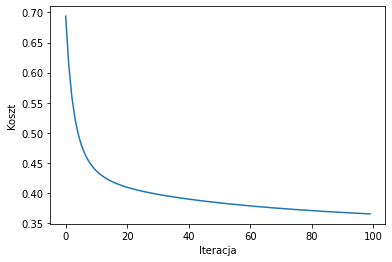

Regresja logistyczna - wersja manualna precyzja: 88.52%


In [19]:
# liczymy wagi, ustawiamy wartości początkowe
def initialize(dimension):
    
    weight = np.full((dimension,1),0.01)
    bias = 0.0
    return weight,bias

#Funkcja sigmoid
def sigmoid(z):
    
    y_head = 1/(1+ np.exp(-z))
    return y_head

def forwardBackward(weight,bias,x_train,y_train):
    # Forward
    
    y_head = sigmoid(np.dot(weight.T,x_train) + bias)
    #strata
    loss = -(y_train*np.log(y_head) + (1-y_train)*np.log(1-y_head))
    #wyliczanie kosztu
    cost = np.sum(loss) / x_train.shape[1]
    
    # Backward
    #Liczenie pochodnych
    derivative_weight = np.dot(x_train,((y_head-y_train).T))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"Derivative Weight" : derivative_weight, "Derivative Bias" : derivative_bias}
    
    return cost,gradients

def update(weight,bias,x_train,y_train,learningRate,iteration) :
    costList = []
    index = []
    
    #każda iteracja to aktualizacja wagi oraz odchylenia
    for i in range(iteration):
        cost,gradients = forwardBackward(weight,bias,x_train,y_train)
        weight = weight - learningRate * gradients["Derivative Weight"]
        bias = bias - learningRate * gradients["Derivative Bias"]
        
        costList.append(cost)
        index.append(i)

    parameters = {"weight": weight,"bias": bias}
    
    print("Iteracja:",iteration)
    print("Koszt:",cost)

    plt.plot(index,costList)
    plt.xlabel("Iteracja")
    plt.ylabel("Koszt")
    plt.show()

    return parameters, gradients


#predykcja choroby
def predict(weight,bias,x_test):
    z = np.dot(weight.T,x_test) + bias
    y_head = sigmoid(z)

    y_prediction = np.zeros((1,x_test.shape[1]))
    
    for i in range(y_head.shape[1]):
        if y_head[0,i] <= 0.5:
            y_prediction[0,i] = 0
        else:
            y_prediction[0,i] = 1
    return y_prediction

def logistic_regression(x_train,y_train,x_test,y_test,learningRate,iteration):
    dimension = x_train.shape[0]
    weight,bias = initialize(dimension)
    
    parameters, gradients = update(weight,bias,x_train,y_train,learningRate,iteration)

    y_prediction = predict(parameters["weight"],parameters["bias"],x_test)
    
    accuracy = (100 - np.mean(np.abs(y_prediction - y_test))*100)
    accuracies["Regresja logistyczna"] = accuracy
    
    print("Regresja logistyczna - wersja manualna precyzja: {:.2f}%".format(accuracy))
    
logistic_regression(x_train,y_train,x_test,y_test,1,100)

### Regresja logistyczna - Sklearn

In [20]:
#Użycie regresji logistycznej w implementacji sklearn

lr = LogisticRegression()
lr.fit(x_train.T,y_train.T)
acc = lr.score(x_test.T,y_test.T)*100

accuracies['Regresja logistyczna - sklearn'] = acc
print("Regresja logistyczna sklearn skuteczność {:.2f}%".format(acc))

Regresja logistyczna sklearn skuteczność 90.16%


C:\Users\Przemek\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Regresja logistyczna sklearn w tym przypadku wykazuje większą skuteczność.

### Algorytm K-najbliższych sąsiadów

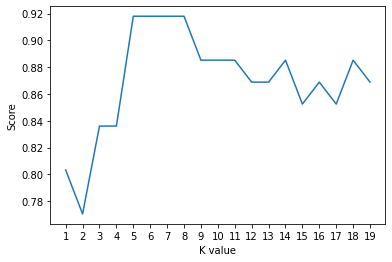

Najlepszy wynik KNN to 91.80%


In [21]:
#Użycie algorytmu k-najbliższych sąsiadów dostarczone przez sklearn


from sklearn.neighbors import KNeighborsClassifier


# Najpierw należy znaleźć najlepsze k
scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(x_train.T, y_train.T)
    scoreList.append(knn2.score(x_test.T, y_test.T))
    
plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100
accuracies['KNN'] = acc
print("Najlepszy wynik KNN to {:.2f}%".format(acc))

Najlepsze k to = 5,6,7,8

### SVC

In [22]:
#Użycie algorytmu SVC (Support Vector Classification) z sklearn

from sklearn.svm import SVC

svc = SVC(random_state = 1)
svc.fit(x_train.T, y_train.T)

acc = svc.score(x_test.T,y_test.T)*100
accuracies['SVC'] = acc
print("Precyzja SVC: {:.2f}%".format(acc))

Precyzja SVC: 88.52%


C:\Users\Przemek\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Naiwny klasyfikator Bayesa

In [23]:
#Naiwny klasyfikator Bayesa z sklearn

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train.T, y_train.T)

acc = nb.score(x_test.T,y_test.T)*100
accuracies['Naiwny klasyfikator Bayesa'] = acc
print("Naiwny klasyfikator Bayesa precyzja: {:.2f}%".format(acc))

Naiwny klasyfikator Bayesa precyzja: 86.89%


### Algorytm drzewa decyzyjnego

Drzewo decyzyjne precyzja: 75.41%


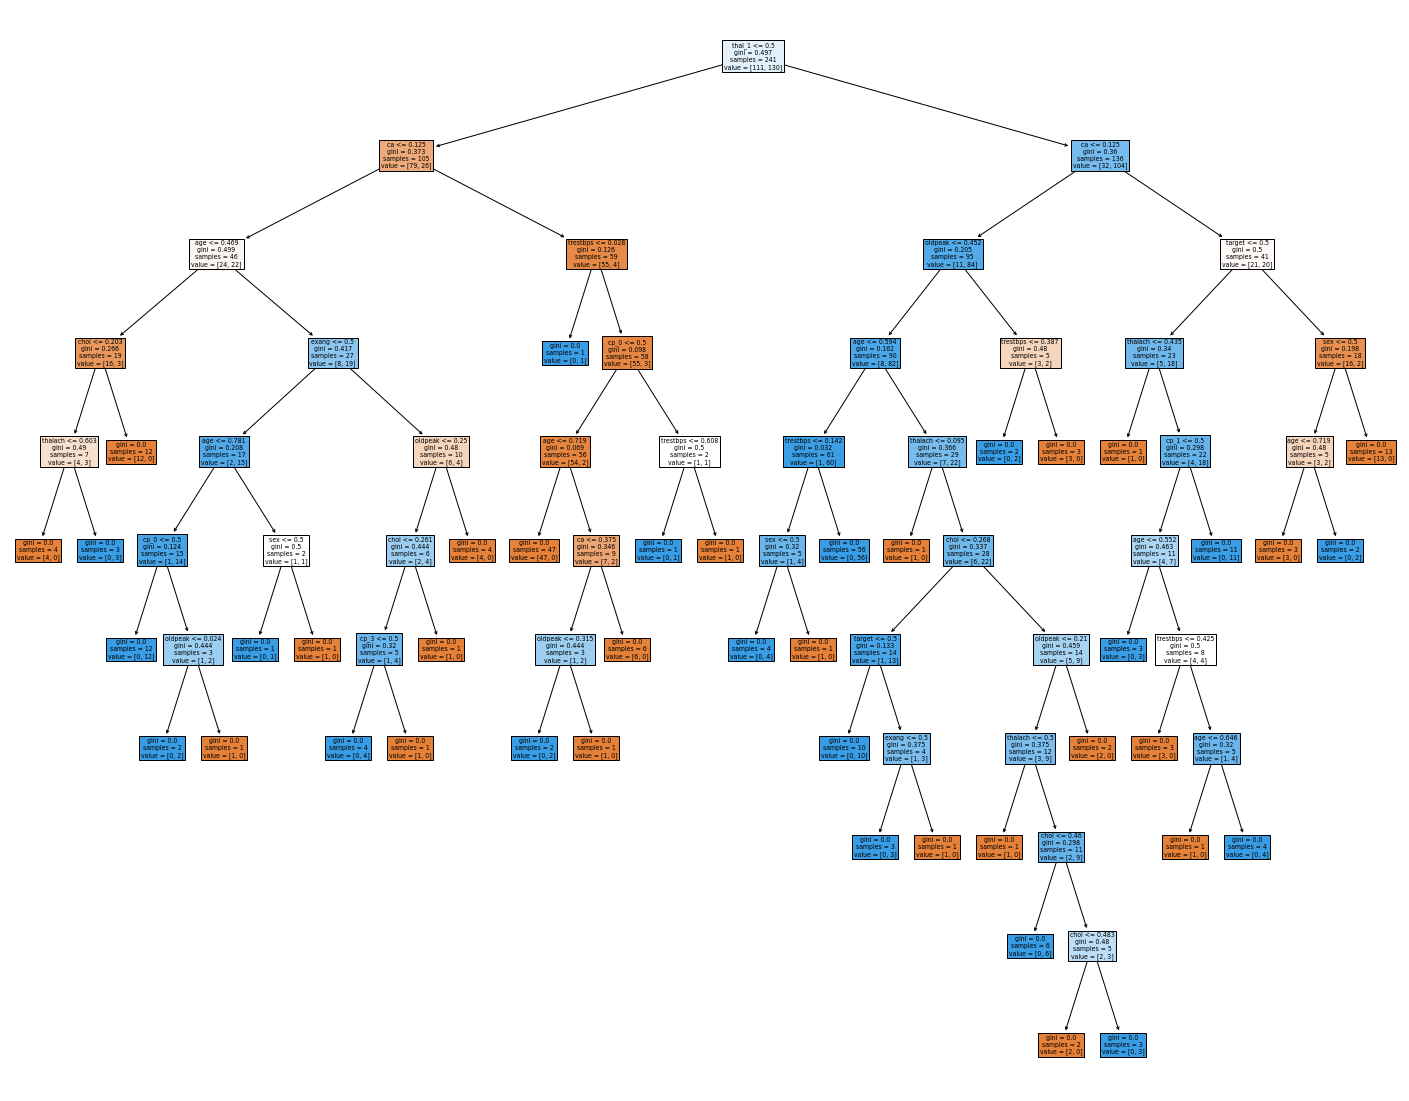

In [24]:
#Algorytm drzewa decyzyjnego z sklearn

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train.T, y_train.T)

acc = dtc.score(x_test.T, y_test.T)*100
accuracies['Drzewo decyzyjne'] = acc
print("Drzewo decyzyjne precyzja: {:.2f}%".format(acc))


#Rysowanie drzewa
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc, feature_names=df.columns.tolist(),
                   filled=True)

In [25]:
#Tekstowa reprezentacja drzewa decyzyjnego.
text_representation = tree.export_text(dtc, feature_names=x_data.columns.tolist())
print(text_representation)


|--- thal_2 <= 0.50
|   |--- ca <= 0.12
|   |   |--- age <= 0.47
|   |   |   |--- chol <= 0.20
|   |   |   |   |--- thalach <= 0.60
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- thalach >  0.60
|   |   |   |   |   |--- class: 1
|   |   |   |--- chol >  0.20
|   |   |   |   |--- class: 0
|   |   |--- age >  0.47
|   |   |   |--- exang <= 0.50
|   |   |   |   |--- age <= 0.78
|   |   |   |   |   |--- cp_1 <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- cp_1 >  0.50
|   |   |   |   |   |   |--- oldpeak <= 0.02
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- oldpeak >  0.02
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  0.78
|   |   |   |   |   |--- sex <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- sex >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- exang >  0.50
|   |   |   |   |--- oldpeak <= 0.25
|   |   |   |   |   |--- chol <= 0.26
|   |   |   |   |   |   |--- thal_0 <

### Las losowy

In [26]:
# Las losowy z sklearn

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1)
rf.fit(x_train.T, y_train.T)

acc = rf.score(x_test.T,y_test.T)*100
accuracies['Las losowy'] = acc
print("Las losowy skuteczność : {:.2f}%".format(acc))

Las losowy skuteczność : 88.52%


### Porównanie skuteczności różnych algorytmów

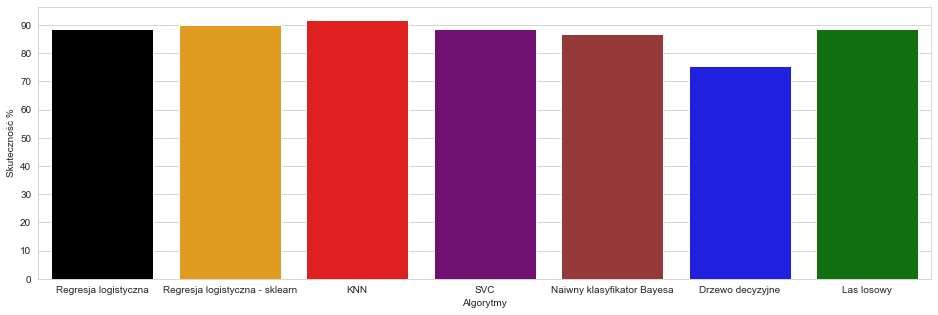

In [27]:
colors = ["black", "orange", "red", "purple","brown","blue", "green"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Skuteczność %")
plt.xlabel("Algorytmy")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

Jak widać najgorszą precyzję wykazuje algorytm drzewa decyzyjnego, a najlepszą algorytm K-najbliższych sąsiadów.

### Macierze pomyłek

Poniżej zostaną pokazane macierze pomyłek poszczególnych algorytmów.

In [28]:
y_head_lr = lr.predict(x_test.T)
knn3 = KNeighborsClassifier(n_neighbors = 3)
knn3.fit(x_train.T, y_train.T)
y_head_knn = knn3.predict(x_test.T)
y_head_svc = svc.predict(x_test.T)
y_head_nb = nb.predict(x_test.T)
y_head_dtc = dtc.predict(x_test.T)
y_head_rf = rf.predict(x_test.T)

from sklearn.metrics import confusion_matrix

#wyliczanie wartości dla macierzy pomyłek
cm_lr = confusion_matrix(y_test,y_head_lr)
cm_knn = confusion_matrix(y_test,y_head_knn)
cm_svc = confusion_matrix(y_test,y_head_svc)
cm_nb = confusion_matrix(y_test,y_head_nb)
cm_dtc = confusion_matrix(y_test,y_head_dtc)
cm_rf = confusion_matrix(y_test,y_head_rf)

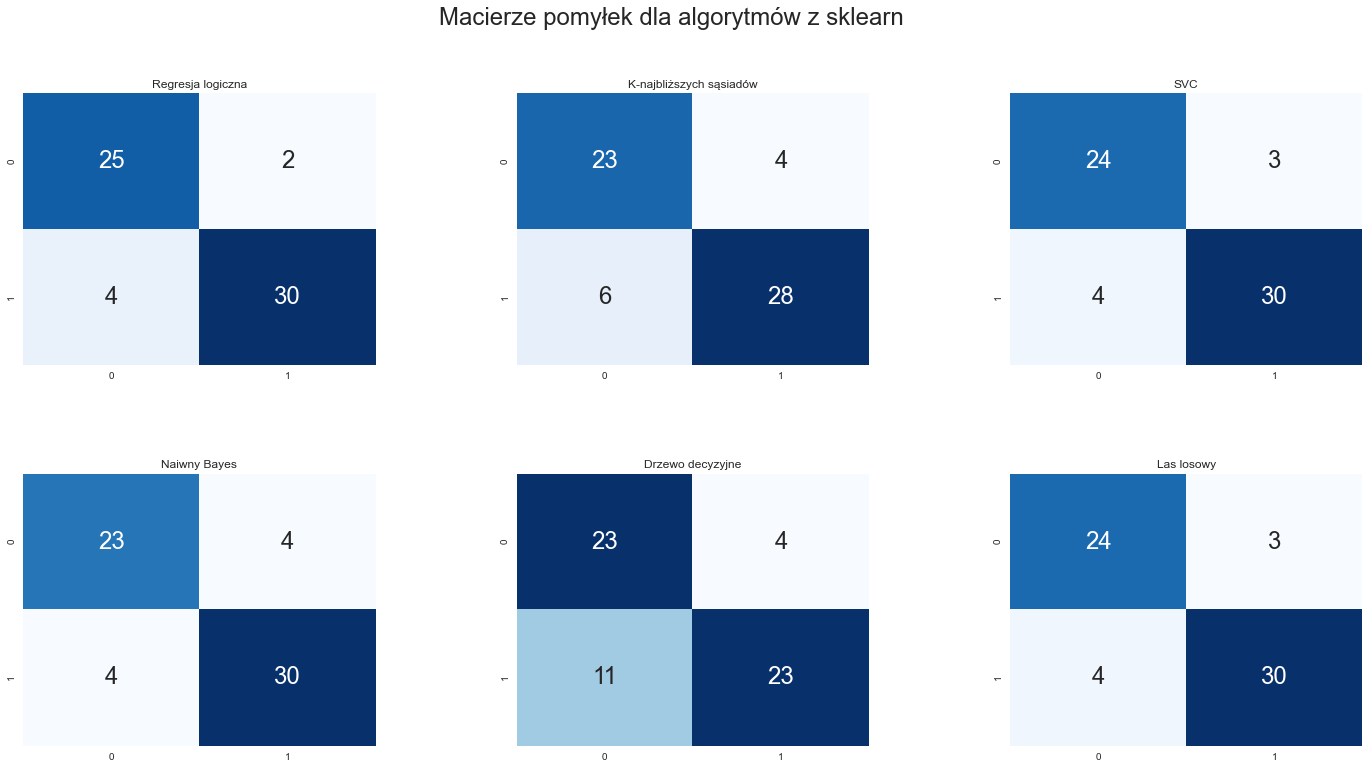

In [29]:

#Wyświetlanie macierzy pomyłek

plt.figure(figsize=(24,12))

plt.suptitle("Macierze pomyłek dla algorytmów z sklearn",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Regresja logiczna")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("K-najbliższych sąsiadów")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,3)
plt.title("SVC")
sns.heatmap(cm_svc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Naiwny Bayes")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("Drzewo decyzyjne")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,6)
plt.title("Las losowy")
sns.heatmap(cm_rf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()